In [1]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Import Data

In [2]:
df = pd.read_csv('./Reddit_data/Combined_Yearly_Data/stage5_final2019.csv')
df

,Date,created_utc,score,vader_neu_score,vader_pos_score,vader_neg_score,vader_compound,blob_polarity,blob_subjectivity,sum_posts_x,sum_posts_y,b_cash_price,btc_price,ltc_price,eth_price
0,2019-01-01,2.706142e+11,175,136.468,26.410,11.123,42.7160,24.720324,55.035224,175,175,164.854599,3715.564441,31.979933,137.727646
1,2019-01-02,4.422842e+11,286,225.624,37.963,22.408,42.5077,20.725735,82.114492,286,286,171.827377,3882.304754,33.433681,153.965636
2,2019-01-03,4.577735e+11,296,225.704,46.506,20.787,60.4147,34.251326,98.111408,296,296,162.049927,3795.592741,32.026699,148.796873
3,2019-01-04,3.603619e+11,233,191.788,30.535,10.672,46.2377,27.768522,66.136730,233,233,161.395630,3812.381108,32.404167,152.873631
4,2019-01-07,3.820787e+11,251,194.829,35.885,16.279,40.4055,12.239006,70.893338,247,247,161.243973,3989.631741,37.806274,149.600165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2019-12-31,2.019603e+11,130,91.469,25.459,10.074,27.8508,13.747032,41.516811,128,128,204.623169,7179.957819,41.340073,128.722604
260,2020-01-01,1.956599e+11,124,94.982,20.297,8.720,28.5484,13.026155,38.683947,124,124,204.397537,7174.744012,42.017719,129.887363
261,2020-01-02,2.793038e+11,1411,136.657,25.557,13.783,30.7325,14.069506,51.179923,177,177,195.698563,6955.487580,39.823013,127.055601
262,2020-01-03,2.935215e+11,4390,144.610,28.309,13.078,24.5729,16.375188,50.544828,186,186,222.412979,7291.219505,42.415577,132.970833


In [3]:
target = df[['btc_price']]

### LSTM Modeling

In [4]:
look_back = 4

In [5]:
X = target
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle = False, random_state = 13)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

train_seq = TimeseriesGenerator(X_train_sc, y_train, length = look_back, batch_size = 128)
test_seq = TimeseriesGenerator(X_test_sc, y_test, length = look_back, batch_size = 128)

In [6]:
model = Sequential()

model.add(LSTM(64, input_shape=(3,1), return_sequences = True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='sgd', metrics = ['mae'])

In [7]:
hist = model.fit(train_seq, epochs=80, validation_data = test_seq, verbose = 0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [8]:
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']

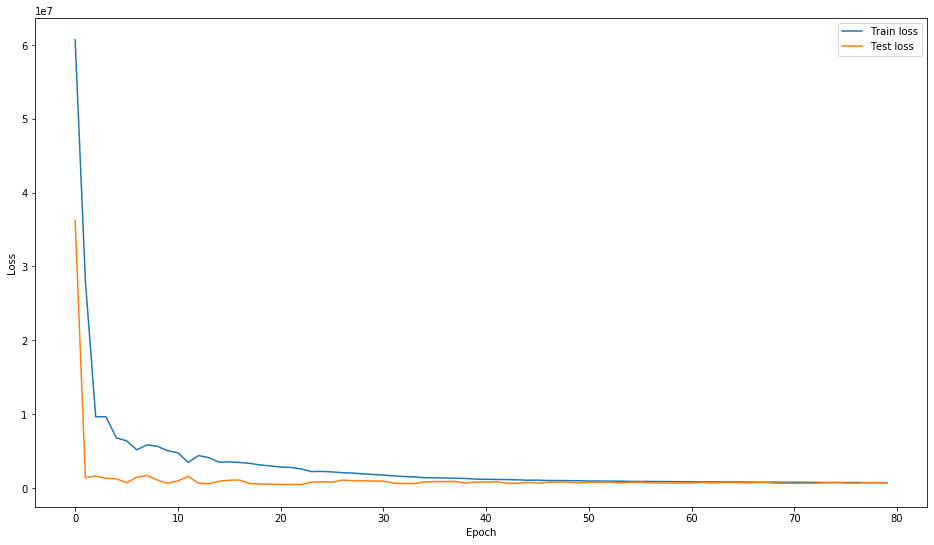

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

### Prediction Forecasting

In [10]:
trainPredict = model.predict(train_seq)
testPredict = model.predict(test_seq)

In [11]:
trainPredict0 = trainPredict[:,0]
trainPredict1 = trainPredict[:,1]
trainPredict2 = trainPredict[:,2]
trainPredict3 = trainPredict[:,3]

In [12]:
testPredict0 = testPredict[:,0]
testPredict1 = testPredict[:,1]
testPredict2 = testPredict[:,2]
testPredict3 = testPredict[:,3]

In [13]:
Trial = (trainPredict0 + trainPredict1 + trainPredict2 + trainPredict3)/4

In [14]:
TrialX = np.append((trainPredict[0]), Trial)

In [15]:
Test = (testPredict0 + testPredict1 + testPredict2 + testPredict3)/4

In [16]:
TestX = np.append(testPredict[0], Test)

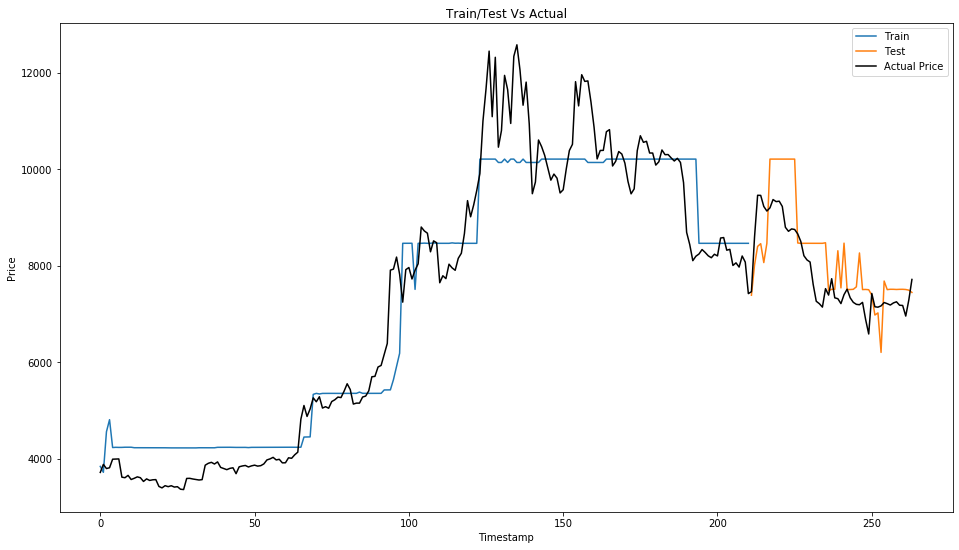

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(TrialX, label = 'Train')
plt.plot([None for i in TrialX] + [x for x in TestX], label = 'Test')
plt.plot(target, label = 'Actual Price', color = 'black')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Train/Test Vs Actual')
plt.legend();

### Model Evaluation

In [18]:
scores = model.evaluate(train_seq, verbose=2)

  ...
    to  
  ['...']
2/2 - 0s - loss: 725037.7500 - mae: 627.1357


In [19]:
print('Model Features: BTC Prices')
model.summary()
print('Model RMSE Score: %2f' % (scores[0]**0.5))
print('Model MAE Score: %2f' % (scores[1]))
print('-' * 65)

Model Features: BTC Prices
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 64)             16896     
_________________________________________________________________
dense (Dense)                (None, 3, 1)              65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Model RMSE Score: 851.491486
Model MAE Score: 627.135742
-----------------------------------------------------------------
